Created on Thu Feb  2 14:12:22 2017

@author: wijers<br>
@editted by: lokhorst

takes a .npz box (region) projection from make_maps, convolves with a PSF, 
selects a region if needed

input: 
 - 2D array repesenting emission
 - angle subtended by an image pixel
 - centre on chip (pixel coordinates)
 - angle of chip long axis wrt image x-axis (radians)
output:
 - photon counts or ergs per second (as in input file) per pixel

In [2]:
import numpy as np
import astropy as asp
import astropy.convolution as cnv
import os.path

import eagle_constants_and_units as cons
#import loadnpz_and_plot as lnp
from cosmo_utils import comoving_distance_cm # loading all of make_maps means the entire read_eagle machinary too 

import matplotlib.pyplot as plt
%matplotlib inline
import warnings

# working units: cgs, radians

radians = 1.
degrees = np.pi/180.
arcmin = 1./60. * degrees
arcsec = 1./3600. * degrees

g = 1.
kg = 10.**3 * g

s = 1.
Hz = 1/s

cm = 1.
nm = 10.**-7 * cm
mum = 10**-4 * cm

erg = 1.

Jy = 10**-23 * erg/(s*cm**2) *1/Hz  



In [3]:
# Dragonfly CCD data (current)
data_version = 1
saved_kernels = 'dragonfly_kernels_dataversion%s' %str(data_version)
saved_abr_fftkernels = 'dragonfly_abr_fftkernels_dataversion%s' %str(data_version)

FOV = (2.6*degrees, 1.9*degrees)
numpix_dr = (3326,2504)
pix_size_phys = 5.4 *mum
pix_size_angle = 2.8 * arcsec
seeing_limit = 1.5*arcsec #typically 1.5--2.0 in long exposures according to the dragonfly paper

def diffraction_limit(wavelength):
    return 0.65*arcsec * wavelength/(450.*nm)
def airy_size(wavelength): #3.1 mum diamater of Airy disc; used as distance to first Airy zero
    return 3.1*mum/2. * wavelength/(450.*nm)

wavelengths = {'halpha': 656.28*nm}

def SB_photonscgs_to_ABmagarcsec(sb):
    fld = sb * cons.planck * (4*np.pi)/3600**2 # flux density: energy / (m**2 s)  /frequency (/arcmin**2)  sufrace brightness: photons / (cm**2 s) /sr       
    return -2.5*np.log10(fld/(3631.*Jy))


In [4]:
# Baseline profiles; normalised to 1 (checked). 
# FWHM is for the Moffat profile alone

# default beta: kolmogorov turbulence for single Moffat
#               2.0 and 7.0 for 2-moffat Racine (1996) fit
def moffat(theta, fwhm, beta=4.765):
    """Profile with default beta suggested by Trujillo et al. 2001. This
    value of beta corresponds to Kolmogorov turbulence.
    """
    ibeta = 1.0/beta
    alpha = fwhm/(2.0*np.sqrt(2.0**ibeta - 1.0))
    coefficient = (beta-1.0)/(np.pi*(alpha**2))
    firstMoffat = coefficient * (1 + (theta/alpha)**2)**(-beta)
    return firstMoffat

def aureole_profile(theta, fwhm, d0=50):
        """Analytical function suggested by Racine (1996) for modelling the full
        PSF aureole. The default value of d0 matches the photographic data of
        King (1971). Note that d0 is specified in units of the FWHM. (It is 50
        and not 100 as in the Racine paper because it is in units of FWHM and
        not HW). Note that constructing a PSF with an Aureole will change the
        effective PSF (likely by a very small amount, assuming only a small
        fraction of the light is in the aureole) but this will not be correctly
        captured by the fwhm property of the PSF."""
        
        d = d0 * fwhm
        coeff = 1./(8*np.pi*d**2)
        cosfac = np.cos(np.arctan(theta/(2*d)))
        return coeff*(cosfac**3.0)

def conv_kernel_and_CCD_project_Airy(image,image_angle_per_pixel,z=0.,proj_dens=10,psf_rad=15):
    wavelength = wavelengths['halpha']*(1.+z) 
    R_airy_zero = airy_size(wavelength)  
    pix_size_image_phys = image_angle_per_pixel/pix_size_angle * pix_size_phys
    seeing_limit_phys = seeing_limit/pix_size_angle * pix_size_phys
    
    kernel_radius = int(np.ceil(psf_rad*R_airy_zero/pix_size_image_phys))
    if not kernel_radius %2: #if kernel radius is even
        kernel_radius +=1
        
    #for_kernel = np.indices((2*kernel_radius+1,)*2) - kernel_radius 
    #for_kernel = np.sqrt(for_kernel[0]**2 + for_kernel[1]**2)*pix_size_image_phys
    
    # centre mode should be the same approach as for the smoothing kernels
    #automatically normalised so sum =1.0, Airy zero radius given in pixels 
    airy_disk_psf = cnv.AiryDisk2DKernel(R_airy_zero/pix_size_image_phys, x_size = 4*kernel_radius+1, y_size = 4*kernel_radius+1, mode = 'oversample')
    
    # For now: use a Gaussian PSF, with the seeing limit as FWHM
    seeing_psf = cnv.Gaussian2DKernel(seeing_limit_phys/pix_size_image_phys/2.3548, x_size = 6*kernel_radius +1, y_size = 6*kernel_radius+1, mode = 'oversample')
    
    # watch out for effects of extending out to larger radii at the corners than edge middles; just include the weird edges for now
    psf_tot = cnv.convolve(seeing_psf,airy_disk_psf,boundary = 'fill',fill_value = 0.)
    
    
    # calculate psf inside the kernel_radius 
    psf_image = cnv.convolve(10**image,psf_tot,boundary = 'wrap')
    
    #proj_grid = np.indices((image.shape[0]*proj_dens,image.shape[1]*proj_dens))
    
    return psf_image

# assumes full projected boxes
def conv_airy(image,key,z=0.,proj_dens=10,psf_rad=15):
    # box size
    if '12' in key:
        (L_x,L_y,L_z) = (12.5,)*3
    if '25' in key:
        (L_x,L_y,L_z) = (25.,)*3

    if '_h' in key:
        L_z = L_z/2.
    if '_q' in key:
        L_z = L_z/4.
        
    # wavelength
    if 'halpha' in key:
         wavelength = wavelengths['halpha']*(1.+z) 
    
    # numpix
    if '_8_' in key or key[-2:] =='_8':
        npix = 8000
    if '_4_' in key or key[-2:] =='_4':
        npix = 4000
    if '_2_' in key or key[-2:] =='_2':
        npix = 2000
        

    # angle_per_pix
    comdist = comoving_distance_cm(z)
    longlen = max(L_x,L_y,L_z)/2. * cons.cm_per_mpc  
    if comdist > longlen: # even at larger values, the projection along z-axis = projection along sightline approximation will break down
        adist = comdist/(1.+z)
    else: 
        adist = longlen/(1.+z) 
    angle_per_pix = L_x/npix * cons.cm_per_mpc/adist * radians
    
    return conv_kernel_and_CCD_project_Airy(image,angle_per_pix,z=z,proj_dens = proj_dens,psf_rad = psf_rad)


In [68]:
#####################################################
# Machinery for generating and saving these kernels #
#####################################################

abr_fftkernels = {}

def save_abr_fftkernels(skernels = abr_fftkernels):
    if os.path.isfile(saved_abr_fftkernels +'.npz'): # npz file already exists
        current = np.load(saved_kernels +'.npz')
        current_dict = {key: current[key] for key in current.keys()}
        current_dict.update(skernels)
        np.savez(saved_kernels,**current_dict)
    else:
        np.savez(saved_abr_fftkernels,**skernels)
    return 0

def load_abr_fftkernels(version = data_version):
    stored = np.load('dragonfly_abr_fftkernels_dataversion%s.npz' %str(version))
    stored_dict = {key: stored[key] for key in stored.keys()}
    abr_fftkernels.update(stored_dict)
    return 0

# stripped-down verion of the loadnpz_and_plot function
# used for oversampling grids
def imreduce(img, factor):
    """
    img: 2D image array
    factor: factor by which to reduce the number of array elements along each axis
    """

    inimg = img
    inshape = np.array(img.shape)
    
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))
    
    inimg = np.sum(inimg,axis=-1)
    inimg = np.sum(inimg,axis=-1)
    
    inimg = inimg/np.float(factor**2)        

    return inimg.T

def print_debug_string(string,debug):
    if debug:
        print 'DEBUGGING: '+string
    return None

In [92]:
def generate_abr_fftkernel(boxlength,numpix,z,kernel,fwhm,beta,d0,tag = '',plotchecks=False,debug=False):
    '''
    Input parameters: 
    
    input image description: used to calculate angle/pixel and required fft kernel size
        boxlength   [Mpc] (float)
        numpix      number of image pixels (int) 
        z           redshift (float): 
    kernel desciption: basic kernels and combinations thereof
        kernel      (string) one of ['Moffat', 'Aureole']                   
        beta1       beta parameter of the (first) Moffat profile (float)
        beta2       beta parameter of the second Moffat profile (float)
    The beta parameters are unused if the (second) Moffat profile is not used.
    
    Output:
    
    psf             (float array, 2d)
    updates dict of the individual psf models required
        
    '''
    print " STARTING generate_abr_fftkernel for fwhm %s, beta %s..."%(fwhm,beta)
    # angle_per_pix in input and ouput images
    comdist = comoving_distance_cm(z)
    print_debug_string('comoving distance (cm): '+str(comdist),debug)
    longlen = float(boxlength) * cons.cm_per_mpc  
    print_debug_string('longlen (the boxlength in cm): '+str(longlen),debug)
    if comdist > longlen/2.: # even at larger values, the projection along z-axis = projection along sightline approximation will break down
        adist = comdist/(1.+z)
        print_debug_string('angular diameter distance (comoving distance divided by cosmological factor): '+str(adist),debug)
    else: 
        adist = longlen/2./(1.+z) 
        print_debug_string('adist (half the boxlength, divided by cosmological factor): '+str(adist),debug)
    image_angle_per_pixel = longlen/(1.+z)/numpix *1./adist * radians # these functions work in units of angles, (1+z) factor to make not comoving?
    print_debug_string('image angle per pixel (arcsec): '+str(image_angle_per_pixel*206265),debug)
    # fft, ifft checked: correct behaviour on constant and delta functions; 
    # slight errors occur in normalisation
    # in product of delta functions, the peak does shift, but the sum and shape are intact
    # oversample functions and take averages to get the pixel kernel values
    'Generate an index array containing x and y values (basegrid[0] is y values and basegrid[1] is x values)'
    'the size of each index array is 10*numpix x 10*numpix (so 10 times the size of the image array along each axis)'
    'the size will get reduced later (when creating the psf)'
    factor = 10.
    basegrid = np.indices((factor*numpix,factor*numpix)) - factor*numpix/2 #(not exactly centered to avoid artifical smearing over at least 4 pixels)
    'Generate the array of angles from the index array (radius = sqrt(x**2 + y**2) and divide the image angle by 10 since'
    'index array is 10x bigger along each axis.'
    theta = np.sqrt(basegrid[0]**2 + basegrid[1]**2)*image_angle_per_pixel/factor    
    del basegrid
    
    # should be periodic; no light is lost, and all light contributes to each point. 
    print(" Calculting PSF.\n")    
    if kernel == 'Moffat':
        'Create the psf and reduce it in size by a factor of 10'
        #psf = imreduce(moffat(theta, fwhm, beta),factor)
        fullrespsf = moffat(theta, fwhm, beta)
        'Normalize the psf'
       # fullrespsf = fullrespsf/np.sum(fullrespsf)
        print_debug_string('Integral of kernel (not one yet): %s'%np.sum(fullrespsf),debug)
        #psf  = psf/np.sum(psf)
        'Reduce the size of the psf'
        psf = imreduce(fullrespsf/np.sum(fullrespsf),factor)*factor**2 # times by 100 to conserve the flux
        print_debug_string('Integral of kernel (not one yet): %s'%np.sum(psf),debug)
        print(" Fourier transforming PSF.\n")
        ftpsf = np.fft.rfft2(psf)
        abr_fftkernels.update({'(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta)) + tag: ftpsf})
        
    elif kernel == 'Aureole':
        psf = imreduce(aureole_profile(theta, fwhm, d0),factor)
       # psf = np.sum(psf)  # DEB
        psf = psf/np.sum(psf)  # DEB
        print(" Fourier transforming PSF.\n")
        ftpsf = np.fft.rfft2(psf)
        abr_fftkernels.update({'(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag: ftpsf})
    
    else:
        print(' %s is not a valid kernel'%str(kernel))
    
    if plotchecks:
        'plot checks'
        'we want an extracted 1d profile from the kernel to match the 1d profile that we get from the Moffat'
        'the full res profile does not match because normalized to sum of 1 across whole 2d kernel'
        'the reduced profile matches better because its been smoothed out.'
        checkpsf = np.fft.irfft2(ftpsf)

        fig, (ax1,ax2,ax3) = plt.subplots(1,3)
        ax1.imshow(fullrespsf/np.sum(fullrespsf))
        ax1.set_title('full resolution')
        ax2.imshow(psf)
        ax2.set_title('reduced resolution')
        ax3.imshow(checkpsf)
        ax3.set_title('inverse fft')
        plt.show()
    
        print 'sum of inverse fft psf: %s'%np.sum(checkpsf)
    
       # fig,(ax2) = plt.subplots(1,1)
        fig,(ax2,ax1) = plt.subplots(1,2)

        shape = psf.shape[0]
        print shape
        ax2.plot(psf[shape/2],color='cyan',label='imreduced psf')
    
        shape2 = theta.shape[0]
        print shape2
        flatpsf = moffat(theta[shape2/2], fwhm, beta)
        maxflat= np.max(flatpsf/np.sum(flatpsf))
        maxpsf = np.max(psf[shape/2])
        ax2.plot(np.arange(shape2)/factor,flatpsf/np.sum(flatpsf)-maxflat+maxpsf,\
                 linestyle='--',color='r',label='flat psf (calculated straight from Moffat)')
    
        maxcheck= np.max(checkpsf[shape/2])
        ax2.plot(checkpsf[shape/2]-maxcheck+maxpsf,color='g',linestyle='--',label='inverse fft psf')

        shape1 = fullrespsf.shape[0]
        print shape1
        maxfullres = np.max(fullrespsf[shape1/2]/np.sum(fullrespsf[shape1/2]))
        ax2.plot(np.arange(shape1)/factor,fullrespsf[shape1/2]/np.sum(fullrespsf[shape1/2])-maxfullres+maxpsf,\
                 color='orange',label='full res psf - norm along axis')
        maxfullres = np.max(fullrespsf[shape1/2]/np.sum(fullrespsf))
        ax2.plot(np.arange(shape1)/factor,fullrespsf[shape1/2]/np.sum(fullrespsf)-maxfullres+maxpsf,\
                 color='b',label='full res psf - norm throughout')
        plt.legend()
        ax2.set_title('Want imreduced psf to match full res psf - change factor')
       # plt.show()
    
       # fig,(ax) = plt.subplots(1,1)
        ax1.plot(psf[shape/2],color='b',label='original psf')
        ax1.plot(np.arange(shape2)/factor,flatpsf/np.sum(flatpsf),\
                 linestyle='--',color='r',label='flat psf')
        ax1.plot(checkpsf[shape/2],color='g',label='inverse fft psf')
        ax1.plot(np.arange(shape1)/factor,fullrespsf[shape1/2]*factor**2,color='orange',label='full res psf')
        plt.show()
    
       # fig,(ax) = plt.subplots(1,1)
       # maxfullres = np.max(fullrespsf[shape1/2]/np.sum(fullrespsf[shape1/2]))
       # ax.plot(fullrespsf[shape1/2]/np.sum(fullrespsf[shape1/2]),color='orange',label='full res psf - norm along axis')
       # ax.plot(flatpsf/np.sum(flatpsf),linestyle='--',color='r',label='flat psf (calculated straight from Moffat)')
       # plt.show()

    
    print " FINISHED generate_abr_fftkernel.\n"
    return ftpsf


In [93]:
def conv_image_abr(img,boxlength,numpix,z,kernel,fwhm,beta1='auto',beta2='auto',d0='auto',m1f = 'auto',mf='auto',af = 'auto',pf = 0.,tag = '',debug=False,plotchecks=False):
    '''
    Input parameters: 
    
    input image description: used to calculate angle/pixel and required fft kernel size
        image       (float array, 2d)
        boxlength   [cMpc] (float)
        numpix      number of image pixels (int) 
        z           redshift (float): 
    kernel desciption: basic kernels and combinations thereof
        kernel      (string) one of
                    ['Moffat', '2Moffat', 'Aureole', 'Point', '2MoffatAureole']
                    The 'Point' option does nothing, and is just a way to get
                    a full fft that only smears part of the light.
        beta1       beta parameter of the (first) Moffat profile (float)
        beta2       beta parameter of the second Moffat profile (float)
        mr1         fraction of the Moffat light in the first profile (float)
        mf          fraction of light in the Moffat profile(s)
        af          fraction of light in the Aureole profile
        pf          fraction of light not spread out (float or 'auto')
        tag         kernel dict entry tag (string)
    The beta parameters are unused if the (second) Moffat profile is not used;
    the fraction parameters are always used, so that only a part of the light 
    can be spread. (The remainder is only put into the point fraction if it is
    set to 'auto'.)
    No check is performed on whether the fractions add up to one.

    Output:
    
    image convolved with the chosen psf model (float array, 2d)   
    abr_fftkernels updated with the individual psf models required
    
    '''
    print 'STARTING convolution...'
    print 'img shape: (%s,%s), boxlength: %s Mpc,numpix: %s,z: %s,kernel: %s,fwhm: %s arcsec. \n'%\
                (img.shape[0],img.shape[1],boxlength,numpix,z,kernel,fwhm)

    # check kernel choice and point fraction:
    if kernel not in ['Moffat', '2Moffat', 'Aureole', 'Point', '2MoffatAureole']:
        print('Invalid kernel choice.')
        return None
    
    # set default values for the chosen profile (following Arbraham ipython)
    if kernel == 'Moffat':
        # only normalisation parameter is mf; mr, af are ignored except for auto pf setting     
        if mf == 'auto':
            mf = 1.
        af = 0.
        if beta1 == 'auto':
            beta1 = 4.765 # kolmogorov turbulence
    
    elif kernel == '2Moffat':
        if mf == 'auto':
            mf =1.
        if m1f == 'auto':
            m1f = 0.8
        if beta1 == 'auto':
            beta1 = 7.0
        if beta2 == 'auto':
            beta2 = 2.0
        af = 0. 
    
    elif kernel == 'Aureole':
        if d0 == 'auto':
            d0 = 50.
        if af == 'auto':
            af = 1.            
        mf = 0.

    elif kernel == 'Point':
        if pf == 'auto':
            pf = 1.

    elif kernel == '2MoffatAureole':
        # default is the optimistic case from the ipython notebook
        # optimistic:  af = 0.02  pessimistic:   af = 0.1   (cirrus)
        # optimistic: fwhm = 3.0  pessimistic:  fwhm = 6.0 in arcsec
        
        if af == 'auto' and mf =='auto':
            af = 0.02
            mf = 0.98
        elif mf == 'auto':
            mf = 1.- af
        elif af == 'auto':
            af = 1. - mf
        
        if m1f == 'auto':
            m1f = 0.8

        if beta1 == 'auto':
            beta1 = 7.0
        if beta2 == 'auto':
            beta2 = 2.0
        if d0 == 'auto':
            d0 = 50.
            
        print 'af: %s,mf: %s, m1f: %s,beta1: %s,beta2: %s,d0: %s'%(af,mf,m1f,beta1,beta2,d0)
        
    if fwhm == 'auto':
        fwhm = 3.0*arcsec # working units are radians
        
    if pf == 'auto' and kernel != 'Point':
        pf = 1. - af - mf
               
    # generate the kernels, or take from earlier calculations
    if kernel == 'Moffat':
        print ' Generating the Moffat kernel...\n'
        #if '(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),'Moffat',str(fwhm),str(beta1)) + tag in abr_fftkernels.keys():
        #    print 'Loading from the dictionary...'
        #    ftpsf = abr_fftkernels['(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta1)) + tag]
        #else:
        ftpsf = generate_abr_fftkernel(boxlength,numpix,z,'Moffat',fwhm,beta1,d0,tag = tag, debug=debug)

        ftpsf = ftpsf*mf   
    
    elif kernel == '2Moffat'  or kernel == '2MoffatAureole': 
        print ' Generating the 2Moffat or 2MoffatAureole kernel...\n'
        #if '(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),'Moffat',str(fwhm),str(beta1)) + tag in abr_fftkernels.keys():
        #    ftpsf1 = abr_fftkernels['(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta1)) + tag]
        #else:
        ftpsf1 = generate_abr_fftkernel(boxlength,numpix,z,'Moffat',fwhm,beta1,d0,tag = tag, debug=debug)
        
        #if '(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),'Moffat',str(fwhm),str(beta2)) + tag in abr_fftkernels.keys():
        #    ftpsf2 = abr_fftkernels['(%s,%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm),str(beta2)) + tag]
        #else:        
        ftpsf2 = generate_abr_fftkernel(boxlength,numpix,z,'Moffat',fwhm,beta2,d0,tag = tag, debug=debug)
        
        ftpsf = mf*(m1f*ftpsf1 + (1.-m1f)*ftpsf2) # linearity property of Fourier transforms
        
        if plotchecks:
            'plot a check'
            fig,ax=plt.subplots(1,1)
            checkpsf1 = np.fft.irfft2(ftpsf1)
            checkpsf2 = np.fft.irfft2(ftpsf2)
            checkpsf = np.fft.irfft2(ftpsf)
            ax.plot(checkpsf[checkpsf.shape[0]/2],color='g',linestyle='--',label='both',linewidth=2)
            ax.plot(m1f*checkpsf1[checkpsf1.shape[0]/2],color='b',linestyle='--',label='1')
            ax.plot((1.-m1f)*checkpsf2[checkpsf2.shape[0]/2],color='r',linestyle='--',label='2')
            plt.legend()
            plt.show()

        del ftpsf1
        del ftpsf2
        
        if kernel == '2MoffatAureole':
            #if '(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag in abr_fftkernels.keys():
            #    ftpsf += af* abr_fftkernels['(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag]
            #else:
            ftpsf = ftpsf + af*generate_abr_fftkernel(boxlength,numpix,z,'Aureole',fwhm,beta1,d0,tag = tag, debug=debug)

    elif kernel == 'Aureole':
        print ' Generating the Aureole kernel...\n'
        #if '(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag in abr_fftkernels.keys():
        #    ftpsf = abr_fftkernels['(%s,%s,%s,%s,%s)'%(str(boxlength),str(numpix),str(z),kernel,str(fwhm*d0)) + tag]
        #else:
        ftpsf = generate_abr_fftkernel(boxlength,numpix,z,'Aureole',fwhm,beta1,d0,tag = tag, debug=debug)
        ftpsf = af*ftpsf
    
    elif kernel == 'Point':
        print ' Generating the Point kernel...\n'
        dim2 = numpix/2 + 1
        ftpsf = np.ones((numpix,dim2)) # FT of a delta function
    else: 
        print('Some error in kernel selection for generation. Time to debug.')    

    if pf > 1e-5:
        print 'DOING SOMETHING'
        dim2 = numpix/2 + 1
        ftpsf += pf* np.ones((numpix,dim2))
        
    if np.abs(mf+pf+af -1.)>1e-5:
        print('Total flux is changed by a factor of %f!'%(mf+pf+af))
               
    out = np.fft.irfft2(np.fft.rfft2(img)*ftpsf)        
    print 'FINISHED convolution.'
    return out


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


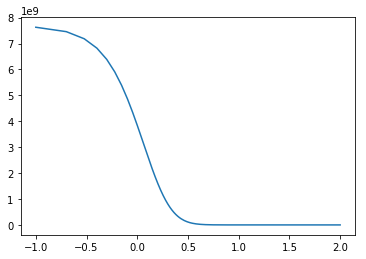

In [16]:
theta = np.arange(0,100,0.1)
fwhm = 2./206265.
flux = moffat(theta/206265, fwhm, beta=4)

plt.plot(np.log10(theta), flux)


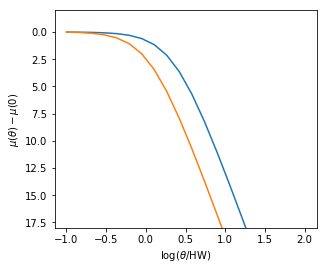

In [143]:
theta = 10.0**np.linspace(-1.0, 2.0, 20)
fwhm = 2
flux = moffat(theta, fwhm, beta=4)
mags = 2.5*np.log10(flux[0])-2.5*np.log10(flux)  # One moffat

plt.plot(np.log10(theta), mags)

theta = 10.0**np.linspace(-1.0, 2.0, 20)
fwhm = 1
flux = moffat(theta, fwhm, beta=4)
mags = 2.5*np.log10(flux[0])-2.5*np.log10(flux)  # One moffat

plt.plot(np.log10(theta), mags)

# Ignore Unicode equal comparison warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.gca().set_ylim(ymin=-2)
    plt.gca().set_ylim(ymax=18)
    xl0,xl1 = plt.gca().get_xlim()
    yl0,yl1 = plt.gca().get_ylim()
    plt.gca().set_aspect(0.83*(xl1-xl0)/(yl1-yl0))
    plt.gca().set_xlabel(r'log($\theta$/HW)')
    plt.gca().set_ylabel(r'$\mu(\theta) - \mu(0)$')
    plt.gca().invert_yaxis()

## Testing
At a comoving distance of 20 Mpc, the redshift is about z = 0.005.<br>
The Dragonfly pixels are 2.8 arcsec, and if we have 21 of them across, that's 2.8x21 arcsec = 60 arcsec, and at a scale of 0.104 kpc/", the boxlength is 0.104 x 60 kpc = 6.1 kpc.<br>
A normal FWHM for Dragonfly data is about 3 arcsec.

In [8]:
print comoving_distance_cm(0.005)
z = 0.005
print 'boxlength: %s'%(2.8*21*0.104) #arcsec * kpc/arcsec
boxlength = 6.1 / 1000. # Mpc
fwhm = 3.0*arcsec

6.81709703692e+25
boxlength: 6.1152


Using a somewhat delta function to test the convolution.

In [97]:
beta=4.765  # default

img = np.zeros((20,20))
numpix = img.shape[0]
#img[numpix/2-2:numpix/2+2,numpix/2-2:numpix/2+2] = 1
img[numpix/2,numpix/2] = 10
z = 0.005
boxlength = (2.8*numpix*0.104) / 1000. # Mpc
fwhm = 3.0*arcsec 


STARTING convolution...
img shape: (20,20), boxlength: 0.005824 Mpc,numpix: 20,z: 0.005,kernel: 2MoffatAureole,fwhm: 1.45444104333e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
DEBUGGING: comoving distance (cm): 6.81709703692e+25
DEBUGGING: longlen (the boxlength in cm): 1.7970988672e+22
DEBUGGING: angular diameter distance (comoving distance divided by cosmological factor): 6.78318113126e+25
DEBUGGING: image angle per pixel (arcsec): 2.71874227281
 Calculting PSF.

DEBUGGING: Integral of kernel (not one yet): 575592335421.0
DEBUGGING: Integral of kernel (not one yet): 1.0
 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
DEBUGGING: comoving distance (cm): 6.81709703692e+25
DEBUGGING: longlen (the boxlength in cm): 1.7970988672e+22
DEBUGGING: angular 

integral before convolution: 10.0
STARTING convolution...
img shape: (20,20), boxlength: 0.005824 Mpc,numpix: 20,z: 0.005,kernel: 2MoffatAureole,fwhm: 1.45444104333e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

FINISHED convolution.
integral after convolution: 10.0


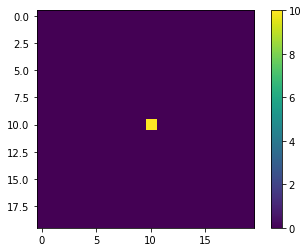

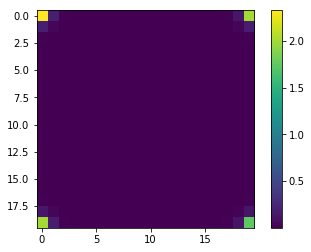

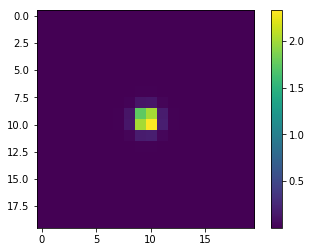

In [103]:
print 'integral before convolution: %s'%np.sum(img)

convolved2MoffatAureole = conv_image_abr(img,boxlength,numpix,z,'2MoffatAureole',fwhm,debug=False)

print 'integral after convolution: %s'%np.sum(convolved2MoffatAureole)

##plt.plot(np.log10(range(5)),convolved[5][5:10])
#plt.plot(np.log10(range(20)),convolved[10])
##plt.ylim(0.003,0.001)

#theta = np.arange(0,2.8*21./2.,0.1)/206265.
#print theta*206265.
#fwhm = 3
#flux = moffat(theta, fwhm)
##plt.plot(np.log10(theta),flux)

#plt.show()

plt.imshow(img)
plt.colorbar()
plt.show()

plt.imshow(convolved2MoffatAureole)
plt.colorbar()
plt.show()

plt.imshow(np.fft.fftshift(convolved2MoffatAureole)) #https://dsp.stackexchange.com/questions/47249/result-of-inverse-fft-is-sometimes-shifted-in-real-space
plt.colorbar()
plt.show()

integral before convolution: 10.0
STARTING convolution...
img shape: (20,20), boxlength: 0.005824 Mpc,numpix: 20,z: 0.005,kernel: 2Moffat,fwhm: 1.45444104333e-05 arcsec. 

 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
 Calculting PSF.

 Fourier transforming PSF.

 FINISHED generate_abr_fftkernel.

FINISHED convolution.
integral after convolution: 10.0


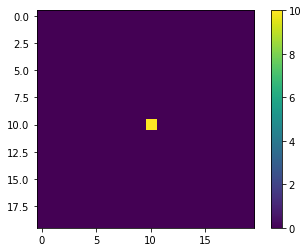

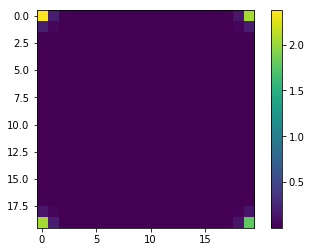

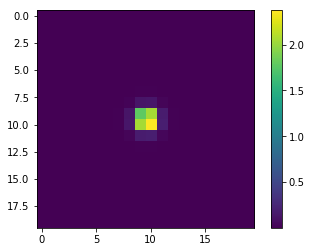

In [109]:
print 'integral before convolution: %s'%np.sum(img)

convolved2Moffat = conv_image_abr(img,boxlength,numpix,z,'2Moffat',fwhm,debug=False)

print 'integral after convolution: %s'%np.sum(convolved2Moffat)

##plt.plot(np.log10(range(5)),convolved[5][5:10])
#plt.plot(np.log10(range(20)),convolved[10])
##plt.ylim(0.003,0.001)

#theta = np.arange(0,2.8*21./2.,0.1)/206265.
#print theta*206265.
#fwhm = 3
#flux = moffat(theta, fwhm)
##plt.plot(np.log10(theta),flux)

#plt.show()



plt.imshow(img)
plt.colorbar()
plt.show()

plt.imshow(convolved2Moffat)
plt.colorbar()
plt.show()

plt.imshow(np.fft.fftshift(convolved2Moffat)) #https://dsp.stackexchange.com/questions/47249/result-of-inverse-fft-is-sometimes-shifted-in-real-space
plt.colorbar()
plt.show()

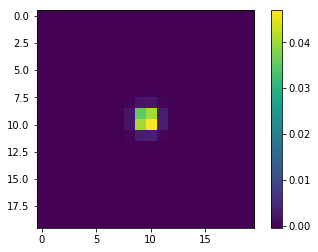

In [105]:
plt.imshow(np.fft.fftshift(convolved2Moffat)-np.fft.fftshift(convolved2MoffatAureole)) #https://dsp.stackexchange.com/questions/47249/result-of-inverse-fft-is-sometimes-shifted-in-real-space
plt.colorbar()
plt.show()